In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(25, 10)

In [2]:
### Collect data
url_confirmed = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_confirmed)

url_deaths = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(url_deaths)

url_recovered = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv'
recovered = pd.read_csv(url_recovered)

In [3]:
print('confirmed shape', confirmed.shape)
print('deaths shape', deaths.shape)
print('recovered shape', recovered.shape)
date_cols = deaths.columns[4:]

confirmed shape (264, 86)
deaths shape (264, 86)
recovered shape (250, 86)


In [4]:
deaths['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [5]:
def metrics(country, metric):
    if metric == 'deaths':
        return deaths[deaths['Country/Region'] == country][date_cols].sum()
    if metric == 'confirmed':
        return confirmed[confirmed['Country/Region'] == country][date_cols].sum()
    if metric == 'recovered':
        return recovered[recovered['Country/Region'] == country][date_cols].sum()
    else:
        d = deaths[deaths['Country/Region'] == country][date_cols].sum()
        c = confirmed[confirmed['Country/Region'] == country][date_cols].sum()
        return d/c

def metrics_plt(countries,m):
    for country in countries:
        metrics(country,m).plot(label=country)
    plt.legend()
    plt.title("Cumulative "+m)

In [6]:
def grads(country, metric):
    if metric == 'deaths':
        a = deaths[deaths['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(a)), index = date_cols)
    if metric == 'confirmed':
        a = confirmed[confirmed['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(a)), index = date_cols)
    if metric == 'recovered':
        a = recovered[recovered['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(a)), index = date_cols)
    else:
        d = deaths[deaths['Country/Region'] == country][date_cols].sum()
        c = confirmed[confirmed['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(d/c)), index = date_cols)

def grads_plt(countries,m):
    for country in countries:
        a = grads(country,m)
        a.plot(label=country)
        plt.legend()
        plt.title("Gradients "+m)

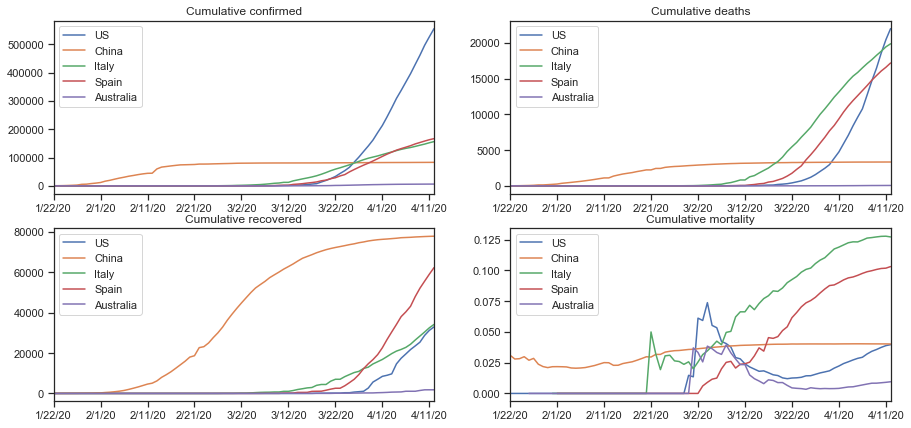

In [7]:
countries = ['US','China','Italy', 'Spain','Australia']
metrics_list = ['confirmed', 'deaths', 'recovered', 'mortality']

figsize(15, 7)
for k, m in enumerate(metrics_list):
    sx = plt.subplot(2, 2, k+1)
    plt.setp(sx.get_yticklabels(), visible=True)
    metrics_plt(countries,m)

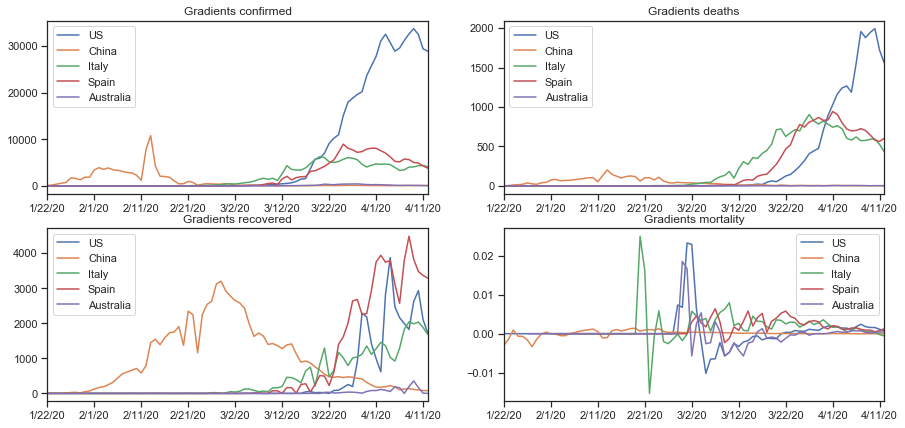

In [8]:
## Gradients
figsize(15, 7)
for k, m in enumerate(metrics_list):
    sx = plt.subplot(2, 2, k+1)
    plt.setp(sx.get_yticklabels(), visible=True)
    grads_plt(countries,m)

# Forcasting Deaths
## Prepare the data for an LSTM model 

This is based on the tutorial https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler

In [50]:
countries = ['US','China','Italy', 'Spain','Australia','Singapore',
             'Korea, South','France','Germany','United Kingdom',
             'Belgium','Netherlands']
countries.sort()
L = date_cols.to_list()
L.insert(0,'Country/Region')
filtr = deaths[deaths['Country/Region'].isin(countries)]
agg = filtr[L].groupby(['Country/Region']).sum()
data = agg[date_cols]
training_set = data[date_cols]

In [51]:
data

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Australia,0,0,0,0,0,0,0,0,0,0,...,28,30,35,40,45,50,51,54,57,60
Belgium,0,0,0,0,0,0,0,0,0,0,...,1143,1283,1447,1632,2035,2240,2523,3019,3346,3600
China,17,18,26,42,56,82,131,133,171,213,...,3326,3330,3333,3335,3335,3337,3339,3340,3343,3343
France,0,0,0,0,0,0,0,0,0,0,...,6520,7574,8093,8926,10343,10887,12228,13215,13851,14412
Germany,0,0,0,0,0,0,0,0,0,0,...,1275,1444,1584,1810,2016,2349,2607,2767,2736,3022
Italy,0,0,0,0,0,0,0,0,0,0,...,14681,15362,15887,16523,17127,17669,18279,18849,19468,19899
"Korea, South",0,0,0,0,0,0,0,0,0,0,...,174,177,183,186,192,200,204,208,211,214
Netherlands,0,0,0,0,0,0,0,0,0,0,...,1490,1656,1771,1874,2108,2255,2403,2520,2653,2747
Singapore,0,0,0,0,0,0,0,0,0,0,...,5,6,6,6,6,6,6,7,8,8


In [12]:
def sliding_windows(data, seq_length):
    x = {}
    y = {}
    for j in range(data.shape[0]):
        x[j] = []
        y[j] = []
        for i in range(data.shape[1]-seq_length-1):
            _x = data[j,i:(i+seq_length)]
            _y = np.array([data[j,i+seq_length]]) ## Need each y element to be an array
            x[j].append(_x)
            y[j].append(_y)
    return x,y

sc = StandardScaler()
training_data = sc.fit_transform(training_set.transpose()).transpose() ## Need to transpose to scale the countries

seq_length = 7 ## Use the previous 7 days to predict the next day
x, y = sliding_windows(training_data, seq_length)

In [13]:
trainX = {}
trainY = {}
testX = {}
testY = {}

for cntry in range(len(data.index)):
    trainX[data.index[cntry]] = []
    trainY[data.index[cntry]] = []
    testX[data.index[cntry]] = []
    testY[data.index[cntry]] = []
    
    train_size = int(len(y[cntry]) * 0.8)
    test_size = len(y[cntry]) - train_size

    dataX = Variable(torch.Tensor(np.array(x[cntry])))
    dataY = Variable(torch.Tensor(np.array(y[cntry])))

    trainX_ = Variable(torch.Tensor(np.array(x[cntry][0:train_size])))
    trainY_ = Variable(torch.Tensor(np.array(y[cntry][0:train_size])))

    testX_ = Variable(torch.Tensor(np.array(x[cntry][train_size:len(x[cntry])])))
    testY_ = Variable(torch.Tensor(np.array(y[cntry][train_size:len(y[cntry])])))
    
    trainX[data.index[cntry]].append(trainX_)
    trainY[data.index[cntry]].append(trainY_)
    testX[data.index[cntry]].append(testX_)
    testY[data.index[cntry]].append(testY_)

In [14]:
train_inout_seq = []
for country in countries:
    for z in zip(trainX[country][0], trainY[country][0]):
        train_inout_seq.append(z)
print(len(train_inout_seq))

708


## Define and train a model

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [16]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [17]:
epochs = 200

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.02981262
epoch:  26 loss: 0.00001265
epoch:  51 loss: 0.00361669
epoch:  76 loss: 0.00709988
epoch: 101 loss: 0.00233370
epoch: 126 loss: 0.00295309
epoch: 151 loss: 0.00059058
epoch: 176 loss: 0.00027085
epoch: 199 loss: 0.0001832690


## Evaluate on the test data

In [52]:
model.eval()

def score(cntry):
    scores = []
    for seq in testX[cntry][0]:
        with torch.no_grad():
            scores.append(model(seq).item())
    return scores

In [53]:
## Return the predicted and actual values back to their original scale
scored = []
for country in countries:
    scored.append(score(country))
unscaled_scores = sc.inverse_transform(pd.DataFrame(scored, index=countries).transpose()).transpose()

actuals = []
for cntry in countries:
    actuals.append(testY[cntry][0].flatten())
unscaled_actuals = sc.inverse_transform(pd.DataFrame(actuals, index=countries).transpose()).transpose()

In [54]:
def plt_predictions(cntry):
    preds = unscaled_scores[countries.index(cntry)]
    actuals = unscaled_actuals[countries.index(cntry)]
    range_values = len(testX[cntry][0])
    xlabels = date_cols[-range_values:]
    plt.plot(actuals, label='actual')
    plt.plot(preds, label='predicted')
    plt.xticks(ticks = range(range_values), labels = xlabels)
    plt.legend()
    plt.title(cntry)

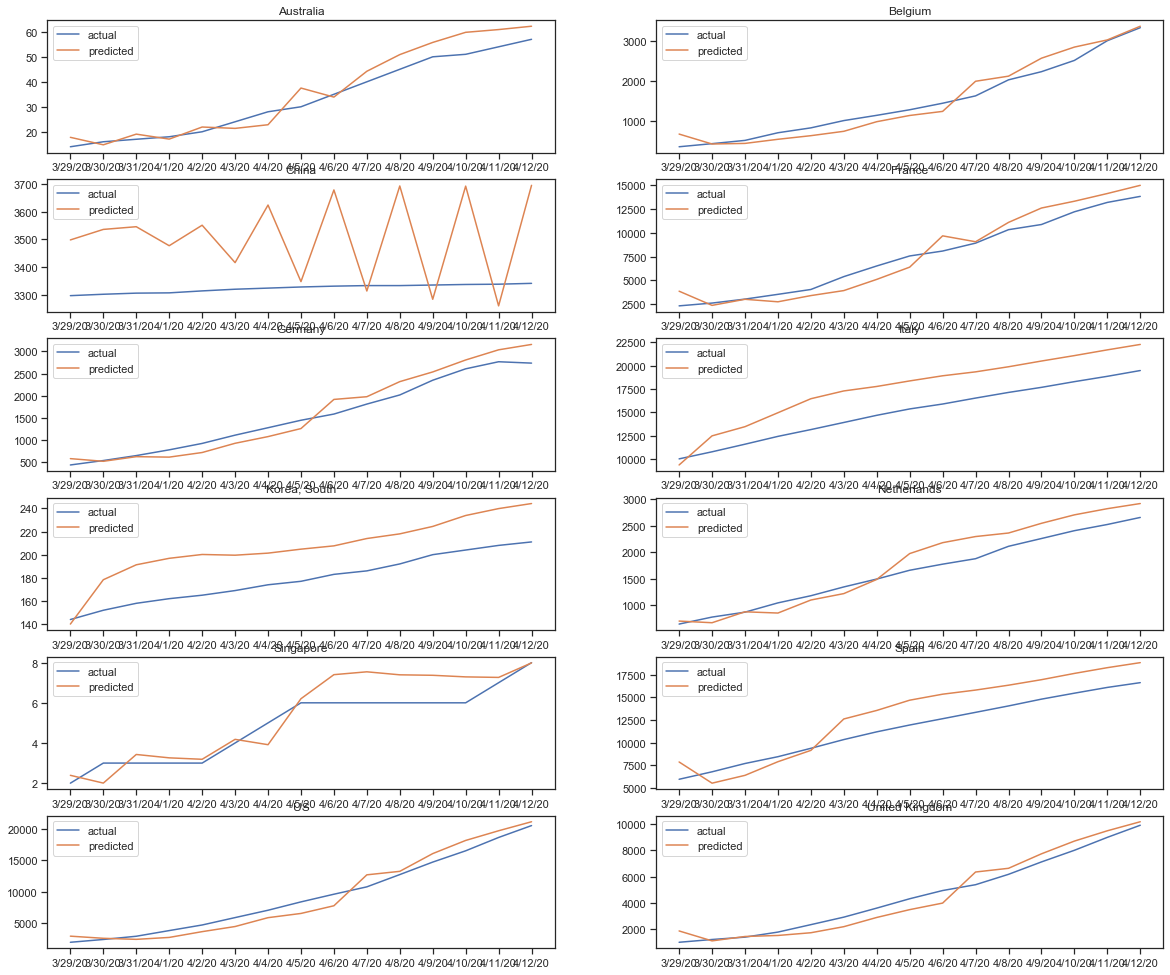

In [55]:
figsize(20, 20)
for k, cntry in enumerate(countries):
    sx = plt.subplot(int(len(countries)/2)+1, 2, k+1)
    plt.setp(sx.get_yticklabels(), visible=True)
    plt_predictions(cntry)

## Forceast the future

In [56]:
def prediction(cntry, days=7):
    scores = []
    initial_seq = testX[cntry][0][-1]
    for i in range(days):
        if scores:
            seq = Variable(torch.Tensor(np.array(testX[cntry][0][-1][:-len(L)].tolist() + scores)))
        else:
            seq = initial_seq
        with torch.no_grad():
            scores.append(model(seq).item())
    return scores

In [57]:
predictions = []
for country in countries:
    predictions.append(prediction(country))
unscaled_forecast = sc.inverse_transform(pd.DataFrame(predictions, index=countries).transpose()).transpose()

In [58]:
def plt_forecast(cntry, days=7):
    preds = unscaled_forecast[countries.index(cntry)]
    range_values = days
    plt.plot(preds, label='predicted')
    plt.xticks(ticks = range(range_values), rotation = 'vertical')
    plt.legend()
    plt.title(cntry)

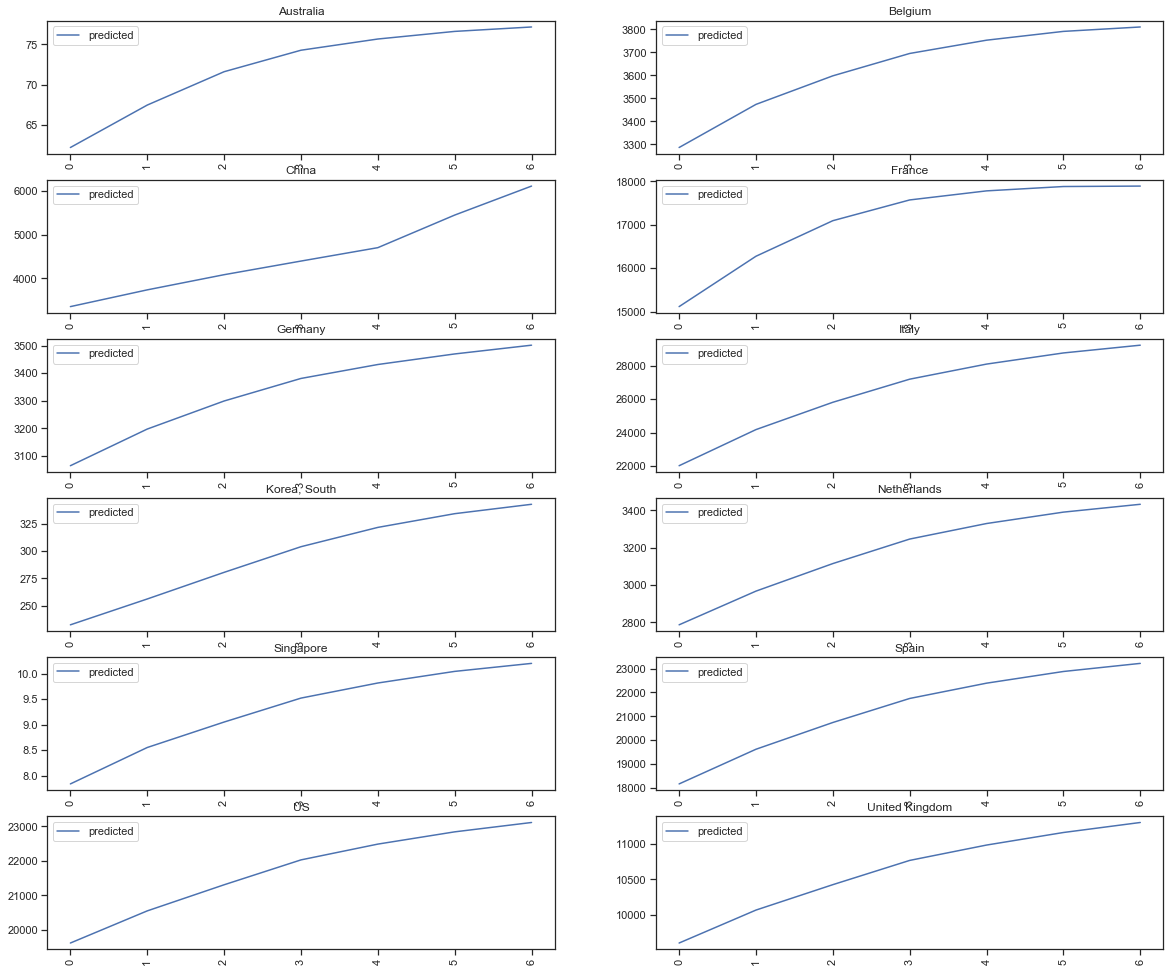

In [59]:
figsize(20, 20)
for k, cntry in enumerate(countries):
    sx = plt.subplot(int(len(countries)/2)+1, 2, k+1)
    plt.setp(sx.get_yticklabels(), visible=True)
    plt_forecast(cntry)